<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [6]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [7]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for sentence in tqdm(dataset['train']['text']):
    sentences.extend([
        sent.lower() for sent in sent_tokenize(sentence)
        if len(word_tokenize(sent)) < word_threshold])

  0%|          | 0/25000 [00:00<?, ?it/s]

In [8]:
print("Всего предложений:", len(sentences))

Всего предложений: 198801


Посчитаем для каждого слова его встречаемость.

In [9]:
words = Counter()

# Расчет встречаемости слов
for sent in sentences:
    tokens = word_tokenize(sent)
    for word in tokens:
        words[word.lower()] += 1

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [10]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

# Наполнение словаря
most_common_words = [word for word, count in words.most_common(vocab_size)]
vocab.update(most_common_words)

In [11]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [12]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [13]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [14]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]

        sentence = self.data[idx]
        words = word_tokenize(sentence.lower())
        for word in words:
            word_index = word2ind.get(word, self.unk_id)
            tokenized_sentence.append(word_index)
        tokenized_sentence += [self.eos_id]
        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [15]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [16]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [17]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [18]:
def train_model(model, train_dataloader, eval_dataloader, criterion, optimizer, num_epoch=5, device='cuda'):
    losses = []
    perplexities = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch + 1}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        avg_train_loss = sum(epoch_losses) / len(epoch_losses)
        eval_perplexity = evaluate(model, criterion, eval_dataloader)

        losses.append(avg_train_loss)
        perplexities.append(eval_perplexity)
    print(f'Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f}, Val Perplexity = {eval_perplexity:.3f}')
    return losses, perplexities

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

**Обобщим класс для нескольких моделей. Добавим параметры для определения значений rnn-блоков, num_layers в них, числа линейных слоёв после них, размер скрытых слоёв, дропаут, размер эмбеддинг слоёв.
В качестве функции активации возьмём ReLU.**

In [19]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, hidden_dim=256, embedding_dim=256,
                 num_layers=1, rnn_type='rnn', dropout=0.1, num_linear_layers=1):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_dim = hidden_dim

        if rnn_type == 'lstm':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                              batch_first=True, dropout=dropout if num_layers > 1 else 0)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                             batch_first=True, dropout=dropout if num_layers > 1 else 0)

        linear_layers = []
        for i in range(num_linear_layers):
            linear_layers.append(nn.Linear(hidden_dim, hidden_dim))
            linear_layers.append(nn.ReLU())
            linear_layers.append(nn.Dropout(dropout))

        self.linear_layers = nn.Sequential(*linear_layers)
        self.projection = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)

        output = self.linear_layers(output)
        logits = self.projection(output)

        return logits

In [21]:
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

**Эксперимент 1: однослойная LSTM с большим скрытым состоянием (512) и dropout=0.2. Функция активации ReLU, learning_rate=0.001.**

In [25]:
# Обучите модель здесь
# Эксперимент 1: однослойная LSTM с большим скрытым состоянием (512) и dropout=0.2. Функция активации ReLU, learning_rate=0.001.
print("Эксперимент 1: LSTM с hidden_dim=512")
model1 = LanguageModel(
    vocab_size=len(vocab),
    hidden_dim=512,
    embedding_dim=512,
    rnn_type='lstm',
    num_layers=1,
    dropout=0.2
).to(device)

optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.001)

train_losses1, eval_ppl1 = train_model(
    model1, train_dataloader, eval_dataloader, criterion, optimizer1, num_epoch=5
)

test_perplexity1 = evaluate(model1, criterion, test_dataloader)
print(f"Test Perplexity: {test_perplexity1:.3f}")

Эксперимент 1: LSTM с hidden_dim=512


Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 5: Train Loss = 3.8941, Val Perplexity = 50.016
Test Perplexity: 49.880


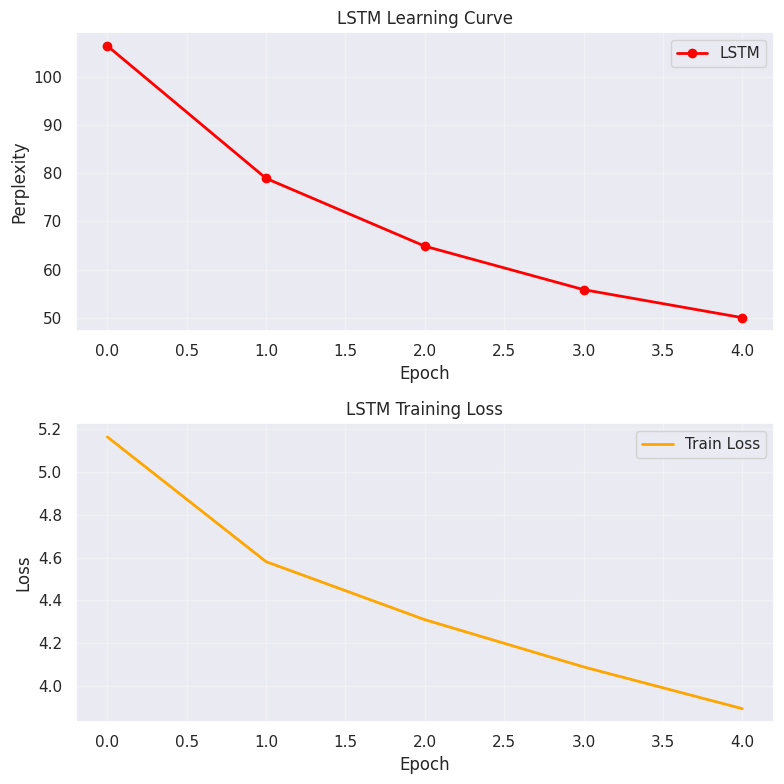

In [32]:
plt.figure(figsize=(8, 8))
# График 1: Perplexity по эпохам
plt.subplot(2, 1, 1)
plt.plot(eval_ppl1, label='LSTM', color='red', linewidth=2, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('LSTM Learning Curve')
plt.grid(True, alpha=0.3)
plt.legend()

# График 2: Loss по эпохам (если есть train_losses2)
plt.subplot(2, 1, 2)
plt.plot(train_losses1, label='Train Loss', color='orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training Loss')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

**Эксперимент 2: двуслойная GRU с 2 линейными слоями после, dropout=0.3, hidden_dim=256, lr=0.001**

In [31]:
# Проведите второй эксперимент
# Эксперимент 2: двуслойная GRU с 2 линейными слоями после, dropout=0.3, hidden_dim=256, lr=0.001
print("Эксперимент 2: двуслойная GRU с 2 линейными слоями после")
model2 = LanguageModel(
    vocab_size=len(vocab),
    hidden_dim=256,
    embedding_dim=256,
    rnn_type='gru',
    num_layers=2,
    dropout=0.3,
    num_linear_layers=2
).to(device)

optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.001)

train_losses2, eval_ppl2 = train_model(
    model2, train_dataloader, eval_dataloader, criterion, optimizer2, num_epoch=5
)

test_perplexity2 = evaluate(model2, criterion, test_dataloader)
print(f"Test Perplexity: {test_perplexity2:.3f}")

Эксперимент 2: двуслойная GRU с 2 линейными слоями после


Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Epoch 5: Train Loss = 4.6481, Val Perplexity = 88.306
Test Perplexity: 87.847


Как видим результат во втором эксперименте хуже.

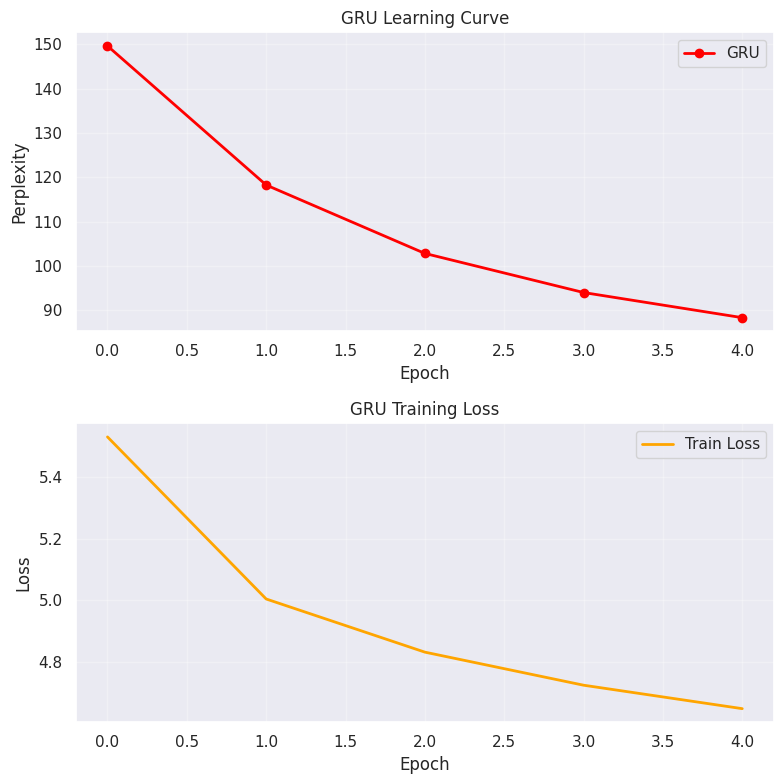

In [33]:
plt.figure(figsize=(8, 8))
# График 1: Perplexity по эпохам
plt.subplot(2, 1, 1)
plt.plot(eval_ppl2, label='GRU', color='red', linewidth=2, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('GRU Learning Curve')
plt.grid(True, alpha=0.3)
plt.legend()

# График 2: Loss по эпохам (если есть train_losses2)
plt.subplot(2, 1, 2)
plt.plot(train_losses2, label='Train Loss', color='orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GRU Training Loss')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

In [34]:
print(f"Test Perplexity LSTM из эксперимента 1: {test_perplexity1:.3f}")
print(f"Test Perplexity GRU из эксперимента 2: {test_perplexity2:.3f}")

Test Perplexity LSTM из эксперимента 1: 49.880
Test Perplexity GRU из эксперимента 2: 87.847


# Проведенные эксперименты

**Эксперимент 1: Однослойная LSTM**

- Архитектура: однослойная LSTM с hidden_dim=512, embedding_dim=512

- Регуляризация: dropout=0.2

- Оптимизация: Adam с lr=0.001

- Количество эпох: 5

- Функция активации: ReLU

**Эксперимент 2: Двуслойная GRU**

- Архитектура: двухслойная GRU с hidden_dim=256, embedding_dim=256

- Дополнительные слои: 2 линейных слоя после RNN

- Регуляризация: dropout=0.3

- Оптимизация: Adam с lr=0.001

- Количество эпох: 5

- Функция активации: ReLU

LSTM показала лучшие результаты. Для улучшения качества этой модели можно поэкспериментировать с гиперпараметрами, нормализацией. Попробовать увеличить количество эпох.
